In [1]:
%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
# sorted just to make it alphabetical
print("The classes are:\n" + ", ".join(sorted(Base.classes.keys())))

The classes are:
measurement, station


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
s = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
q = s.query(func.max(Measurement.date)).first()[0]
print(f"The last date in the data set is {q}")

# Calculate the date one year from the last date in data set.
year_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"The year prior starts on {year_prior}")

The last date in the data set is 2017-08-23
The year prior starts on 2016-08-23


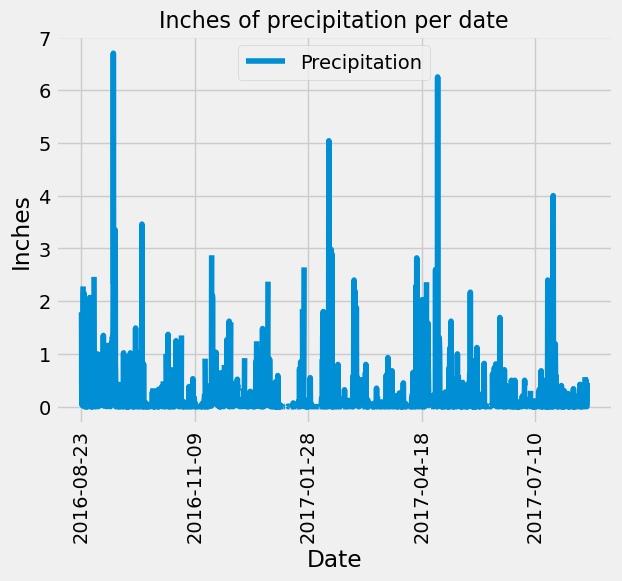

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Perform a query to retrieve the data and precipitation scores
q = (
    s.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= year_prior)
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
rain_df = pd.DataFrame(q, columns=["Date", "Precipitation"])

# Sort the dataframe by date
rain_df = rain_df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(x="Date", y="Precipitation", rot=90)
rain_df["Date"] = pd.to_datetime(rain_df["Date"])

# formatting
plt.title("Inches of precipitation per date", fontsize=16)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.legend(["Precipitation"], loc="best")

# save figure for Readme
plt.savefig("Images/precipitation.png")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# set variables for queries
ms = Measurement.station
mt = Measurement.tobs

In [13]:
# Design a query to calculate the total number of stations in the dataset
print(f"The total number of stations is {s.query(func.count(Station.station)).scalar()}")

The total number of stations is 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
q = s.query(ms, func.count(ms)).group_by(ms).order_by(func.count(ms).desc()).all()
print("    Station, Count of Observations")
for _ in q:
    print(f"{_[0]}, {_[1]}")

# print out the most active station
# note that mas_name is defined here - most_active_station_name
mas_name, mas_count = most_active_station = (
    s.query(ms, func.count(ms)).group_by(ms).order_by(func.count(ms).desc()).first()
)
print(f"\nThe most active station is {mas_name} with {mas_count} measurements")

    Station, Count of Observations
USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511

The most active station is USC00519281 with 2772 measurements


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
low, high, avg = (s.query(func.min(mt), func.max(mt), func.avg(mt)).filter(ms == mas_name).first())
print(f"For temperature(F), the low is {low}, the high is {high}, and the average is {avg:.2f}")

For temperature(F), the low is 54.0, the high is 85.0, and the average is 71.66


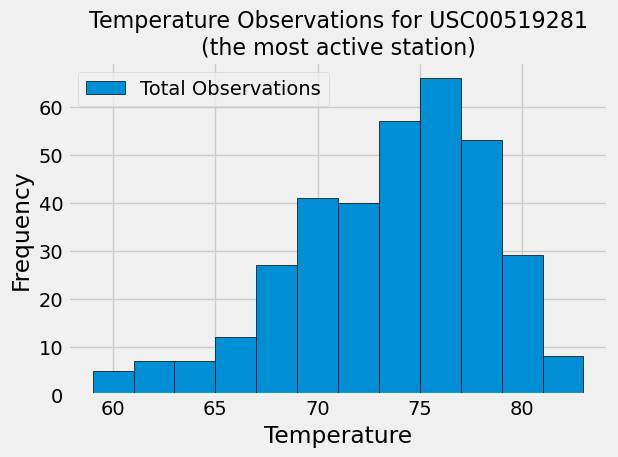

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
q = s.query(mt).filter(ms == mas_name).filter(Measurement.date >= year_prior).all()

# create pandas df
temp_df = pd.DataFrame(q, columns=["Temperature"])

# plot histogram
temp_df.plot.hist(bins=12, edgecolor="black", label="tobs")

# formatting
plt.title("Temperature Observations for USC00519281\n(the most active station)", fontsize=16)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["Total Observations"], loc="best")
plt.tight_layout()

# save figure for Readme
plt.savefig("Images/tobs.png")
plt.show()

# Close Session

In [17]:
# Close Session
s.close()